In [14]:
import pandas as pd
import numpy as np
import math
import helper
import time
import datetime
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score, LeaveOneOut, ShuffleSplit, train_test_split, GridSearchCV 
from sklearn.feature_selection import SelectPercentile, SelectFromModel
import pickle    

# Подгрузка всех таблиц с данными по матчям

In [125]:
# дф с матчами и рейтингом каждой команды с патча 7.01 для Премиум
df_rating_teams_Premium = pd.read_csv('../tabel/table from Datdota/Rating teams/PREMIUM (with double Infamous) 7.00+ to 12.02.18.csv', index_col=0)
# удалить повторяющиеся матчи с Infamous, и сделать реиндекс 
df_rating_teams_Premium = df_rating_teams_Premium.drop(1).reset_index().drop('index', axis=1)

print (len(df_rating_teams_Premium))
df_rating_teams_Premium = df_rating_teams_Premium.drop(
    df_rating_teams_Premium[df_rating_teams_Premium['radiant_name'] == 'Digital Chaos'].index)
print (len(df_rating_teams_Premium))
df_rating_teams_Premium = df_rating_teams_Premium.drop(
    df_rating_teams_Premium[df_rating_teams_Premium['dire_name'] == 'Digital Chaos'].index)
print (len(df_rating_teams_Premium))
df_rating_teams_Premium = df_rating_teams_Premium.drop(
    df_rating_teams_Premium[df_rating_teams_Premium['radiant_team_id'] == 5065748].index)
print (len(df_rating_teams_Premium))
df_rating_teams_Premium = df_rating_teams_Premium.drop(
    df_rating_teams_Premium[df_rating_teams_Premium['dire_team_id'] == 5065748].index)
print (len(df_rating_teams_Premium))
df_rating_teams_Premium = df_rating_teams_Premium.drop(
    df_rating_teams_Premium[df_rating_teams_Premium['radiant_team_id'] == 2672298].index)
print (len(df_rating_teams_Premium))
df_rating_teams_Premium = df_rating_teams_Premium.drop(
    df_rating_teams_Premium[df_rating_teams_Premium['dire_team_id'] == 2672298].index)
print (len(df_rating_teams_Premium))


3729
3686
3608
3564
3541
3503
3464


In [126]:
# # дф с матчами и рейтингом каждой команды с патча 7.01 для Премиум
# df_rating_teams_Premium = pd.read_csv('../tabel/table from Datdota/Rating teams/PREMIUM (with double Infamous) 7.00+ to 12.02.18.csv', index_col=0)
# # удалить повторяющиеся матчи с Infamous, и сделать реиндекс 
# df_rating_teams_Premium = df_rating_teams_Premium.drop(1).reset_index().drop('index', axis=1)

# ДФ с контрпиками (head-to-head) с 6,74-7,10 и до 2018.05.06
df_contrpick = pd.read_csv(('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
                'data from 6.74-7.10 with last day 2018.05.06. 7.00+ to 12.02.18.csv'), index_col=0)

# # ДФ с контрпиками (head-to-head) с 6,74-7,09 и до 2018.05.06
# df_contrpick = pd.read_csv(('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
#                 'data from 6.74-7.09 with last day 2018.05.06. 7.00+ to 12.02.18.csv'), index_col=0)

# # ДФ с контрпиками (head-to-head) с 6,74-7,09 и до дня матча
# df_contrpick = pd.read_csv(('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
#                 'data from 6.74-7.09 before day of match. 7.00+ to 12.02.18.csv'), index_col=0)

# ДФ с метовыми героями
df_meta_heroes = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                             'Meta 7.00+ to 12.02.18.csv', index_col=0)

# ДФ с сигнатурками
df_signatures_heroes = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                                   'Sigantures 7.00+ to 12.02.18.csv', index_col=0)


# Создание основного ДФ для обучения и предсказания

In [127]:
# Соединение всех данных в один ДФ
main = pd.merge(df_rating_teams_Premium, df_contrpick, left_on='match_id', right_on='match_id',how='left')
main = pd.merge(main, df_meta_heroes, left_on='match_id', right_on='match_id',how='left')
main = pd.merge(main, df_signatures_heroes, left_on='match_id', right_on='match_id',how='left')

# # удаление не нужных колонок для обучения
main = main.drop(['match_id', 'start_time', 'radiant_team_id', 'radiant_score', 'dire_team_id',
           'dire_score', 'radiant_name', 'dire_name'], axis=1)
# Оставляю только важные фичи, убираю из рейтинга команд ело32 и ело64
main = main.drop(main.loc[:, 'radiant_current_elo32':'radiant_thirtyDayAvg_elo64'], axis=1)
main = main.drop(main.loc[:, 'dire_current_elo32':'dire_thirtyDayAvg_elo64'], axis=1)
# Заполнить пустые значения на 0
main = main.fillna(0)

In [128]:
len(main)

3464

# Создание обучающих и тестовых данных

In [129]:
# удалть имена команд и сделать обучающие данные и ответы
X = main.drop(['radiant_win'], axis=1)
y = main['radiant_win']

# СДЕЛАТЬ 1 или 0 вместо true false
y = y.astype(int)

# деление на тестовые и обучающую выборку
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
X_train.columns

Index(['radiant_mu_glicko', 'radiant_rating_glicko',
       'radiant_ratingSevenDaysAgo_glicko', 'radiant_sigma_glicko',
       'radiant_mu_glicko2', 'radiant_phi_glicko2', 'radiant_rating_glicko2',
       'radiant_ratingSevenDaysAgo_glicko2', 'dire_mu_glicko',
       'dire_rating_glicko', 'dire_ratingSevenDaysAgo_glicko',
       'dire_sigma_glicko', 'dire_mu_glicko2', 'dire_phi_glicko2',
       'dire_rating_glicko2', 'dire_ratingSevenDaysAgo_glicko2',
       'radiant_H1elo_vs_enemies', 'radiant_H2elo_vs_enemies',
       'radiant_H3elo_vs_enemies', 'radiant_H4elo_vs_enemies',
       'radiant_H5elo_vs_enemies', 'dire_H1elo_vs_enemies',
       'dire_H2elo_vs_enemies', 'dire_H3elo_vs_enemies',
       'dire_H4elo_vs_enemies', 'dire_H5elo_vs_enemies', 'radiant_H1_AvgElo_x',
       'radiant_H2_AvgElo_x', 'radiant_H3_AvgElo_x', 'radiant_H4_AvgElo_x',
       'radiant_H5_AvgElo_x', 'dire_H1_AvgElo_x', 'dire_H2_AvgElo_x',
       'dire_H3_AvgElo_x', 'dire_H4_AvgElo_x', 'dire_H5_AvgElo_x',
       

# Решетчатый поиск на Gradient Bosting

In [130]:
%%time
# # Праметры GB
# param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [10, 25, 50, 100],
#               'max_features': [10, 20, 40]}
param_grid = {'n_estimators': [100], 'max_depth': [10],
              'max_features': [40]}
grid_search_GB = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=-1)

grid_search_GB.fit(X_train,y_train)

print("Наилучшие значения параметров: {}".format(grid_search_GB.best_params_))
print('------------------------------------------------------------------------------------------------')
print ("Модель обученная на данных контрпиков до июня 2018")
print(classification_report(y_test, grid_search_GB.predict(X_test), target_names=['dire_win', 'radiant_win']))

Наилучшие значения параметров: {'max_depth': 10, 'max_features': 40, 'n_estimators': 100}
------------------------------------------------------------------------------------------------
Модель обученная на данных контрпиков до июня 2018
             precision    recall  f1-score   support

   dire_win       0.75      0.71      0.73       419
radiant_win       0.74      0.78      0.76       447

avg / total       0.74      0.74      0.74       866

Wall time: 16.3 s


In [113]:
# save the model to disk
filename = 'grid_search_GB_model v.1.1.a (day 12.02.18 without repeated rating teams) .sav'
pickle.dump(grid_search_GB, open(filename, 'wb'))

In [131]:
%%time
# ДАННЫЕ ПО HEAD-TO-HEAD ДЛЯ ВСЕХ ПАТЧЕЙ ДО ПРЕДЫДУЩЕГО ДНЯ МАТЧЯ
import xgboost as xgb
# fit model no training data
xgb_all_data = xgb.XGBClassifier()
xgb_all_data.fit(X_train, y_train)
print ("Модель обученная на данных контрпиков до июня 2018")
print(classification_report(y_test, xgb_all_data.predict(X_test), target_names=['dire_win', 'radiant_win']))

Модель обученная на данных контрпиков до июня 2018
             precision    recall  f1-score   support

   dire_win       0.75      0.72      0.73       419
radiant_win       0.74      0.77      0.76       447

avg / total       0.74      0.74      0.74       866

Wall time: 180 ms


In [50]:
# save the model to disk
filename = 'xgb_all_data v.1.1 .sav'
pickle.dump(xgb_all_data, open(filename, 'wb'))

# Проверка на новых данных

In [114]:
# Удаление повторющихс команд в рцйтинге команд
# дф с матчами и рейтингом каждой команды с патча 7.01 для Премиум
df_rating_teams_Premium_contr = pd.read_csv('../tabel/table from Datdota/Rating teams/'+
                                      'PREMIUM on 13.02.18 to 12.03.18.csv', index_col=0)
# удалить повторяющиеся матчи с Infamous, и сделать реиндекс 
df_rating_teams_Premium_contr = df_rating_teams_Premium_contr.drop(1).reset_index().drop('index', axis=1)

print (len(df_rating_teams_Premium_contr))
df_rating_teams_Premium_contr = df_rating_teams_Premium_contr.drop(
    df_rating_teams_Premium_contr[df_rating_teams_Premium_contr['radiant_name'] == 'Digital Chaos'].index)
print (len(df_rating_teams_Premium_contr))
df_rating_teams_Premium_contr = df_rating_teams_Premium_contr.drop(
    df_rating_teams_Premium_contr[df_rating_teams_Premium_contr['dire_name'] == 'Digital Chaos'].index)
print (len(df_rating_teams_Premium_contr))
df_rating_teams_Premium_contr = df_rating_teams_Premium_contr.drop(
    df_rating_teams_Premium_contr[df_rating_teams_Premium_contr['radiant_team_id'] == 5065748].index)
print (len(df_rating_teams_Premium_contr))
df_rating_teams_Premium_contr = df_rating_teams_Premium_contr.drop(
    df_rating_teams_Premium_contr[df_rating_teams_Premium_contr['dire_team_id'] == 5065748].index)
print (len(df_rating_teams_Premium_contr))
df_rating_teams_Premium_contr = df_rating_teams_Premium_contr.drop(
    df_rating_teams_Premium_contr[df_rating_teams_Premium_contr['radiant_team_id'] == 2672298].index)
print (len(df_rating_teams_Premium_contr))
df_rating_teams_Premium_contr = df_rating_teams_Premium_contr.drop(
    df_rating_teams_Premium_contr[df_rating_teams_Premium_contr['dire_team_id'] == 2672298].index)
print (len(df_rating_teams_Premium_contr))


381
374
370
359
350
350
350


In [115]:
# # дф с матчами и рейтингом каждой команды с патча 7.01 для Премиум
# df_rating_teams_Premium_contr = pd.read_csv('../tabel/table from Datdota/Rating teams/'+
#                                       'PREMIUM on 13.02.18 to 12.03.18.csv', index_col=0)

# ДФ с контрпиками (head-to-head) с 6,74-7,09 и до 2018.05.06
df_contrpick_contr = pd.read_csv(('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
                'data from 6.74-7.10 with last day 2018.05.06. on 13.02.18 to 12.03.18.csv'), index_col=0)

# # ДФ с контрпиками (head-to-head) с 6,74-7,09 и до дня матча
# df_contrpick = pd.read_csv(('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
#                 'data from 6.74-7.10 before day of match. on 13.02.18 to 12.03.18.csv'), index_col=0)

# ДФ с метовыми героями
df_meta_heroes_contr = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                             'Meta on 13.02.18 to 12.03.18.csv', index_col=0)

# ДФ с сигнатурками
df_signatures_heroes_contr = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                                   'Signatures on 13.02.18 to 12.03.18.csv', index_col=0)


In [117]:
test2 = test


In [118]:
# Соединение всех данных в один ДФ

test = pd.merge(df_rating_teams_Premium_contr, df_contrpick_contr, left_on='match_id', right_on='match_id',how='left')
test = pd.merge(test, df_meta_heroes_contr, left_on='match_id', right_on='match_id',how='left')
test = pd.merge(test, df_signatures_heroes_contr, left_on='match_id', right_on='match_id',how='left')

# # удаление не нужных колонок для обучения
test = test.drop(['match_id', 'start_time', 'radiant_team_id', 'radiant_score', 'dire_team_id',
           'dire_score', 'radiant_name', 'dire_name', 'league_name'], axis=1)
test = test.drop(test.loc[:, 'radiant_H1':'dire_P5'], axis=1)
test = test.dropna()

# Оставляю только важные фичи, убираю из рейтинга команд ело32 и ело64
test = test.drop(test.loc[:, 'radiant_current_elo32':'radiant_thirtyDayAvg_elo64'], axis=1)
test = test.drop(test.loc[:, 'dire_current_elo32':'dire_thirtyDayAvg_elo64'], axis=1)

In [121]:
test = pd.concat([test, test2]).reset_index().drop('index', axis=1)

In [124]:
# Создание контрольной выборки
# удалть имена команд и сделать обучающие данные и ответы
X_contr = test.drop(['radiant_win'], axis=1)
y_contr = test['radiant_win']

# СДЕЛАТЬ 1 или 0 вместо true false
y_contr = y_contr.astype(int)


In [134]:
filename = 'grid_search_GB_model v.1.1.a (day 12.02.18 without repeated rating teams) .sav'
grid_search_GB = pickle.load(open(filename, 'rb'))
print ("Модель обученная на данных контрпиков до июня 2018")
print(classification_report(y_contr, grid_search_GB.predict(X_contr), target_names=['dire_win', 'radiant_win']))

Модель обученная на данных контрпиков до июня 2018
             precision    recall  f1-score   support

   dire_win       0.60      0.62      0.61       248
radiant_win       0.71      0.69      0.70       325

avg / total       0.66      0.66      0.66       573



In [135]:
filename = 'xgb_all_data v.1.1 .sav'
xgb_all_data = pickle.load(open(filename, 'rb'))
print ("Модель обученная на данных контрпиков до июня 2018")
print(classification_report(y_contr, xgb_all_data.predict(X_contr), target_names=['dire_win', 'radiant_win']))

Модель обученная на данных контрпиков до июня 2018
             precision    recall  f1-score   support

   dire_win       0.62      0.65      0.63       248
radiant_win       0.72      0.69      0.71       325

avg / total       0.67      0.67      0.67       573



In [132]:
print ("Модель обученная на данных контрпиков до дня матча")
print(classification_report(y_contr, grid_search_GB.predict(X_contr), target_names=['dire_win', 'radiant_win']))

Модель обученная на данных контрпиков до дня матча
             precision    recall  f1-score   support

   dire_win       0.59      0.63      0.61       248
radiant_win       0.70      0.67      0.69       325

avg / total       0.66      0.65      0.65       573



In [133]:
print ("Модель обученная на данных контрпиков до дня матча")
print(classification_report(y_contr, xgb_all_data.predict(X_contr), target_names=['dire_win', 'radiant_win']))

Модель обученная на данных контрпиков до дня матча
             precision    recall  f1-score   support

   dire_win       0.61      0.59      0.60       248
radiant_win       0.69      0.71      0.70       325

avg / total       0.66      0.66      0.66       573



In [136]:
best_GB = xgb_all_data
# предсказания
predict_GB = best_GB.predict(X_test)
# матрица ошибок
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, predict_GB)
confusion

array([[336,  83],
       [ 71, 376]], dtype=int64)

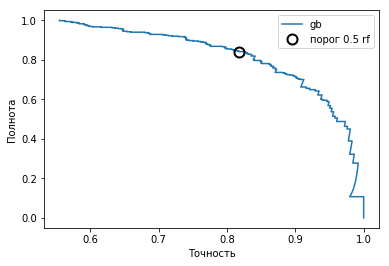

In [137]:
# в RandomForestClassifier есть predict_proba, но нет decision_function
precision_gb, recall_gb, thresholds_gb = metrics.precision_recall_curve(
y_test, best_GB.predict_proba(X_test)[:, 1])

plt.plot(precision_gb, recall_gb, label="gb")
close_default_gb = np.argmin(np.abs(thresholds_gb - 0.5))
plt.plot(precision_gb[close_default_gb], recall_gb[close_default_gb], 'o', c='k',
         markersize=10, label="порог 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Точность")
plt.ylabel("Полнота")
plt.legend(loc="best")
plt.show()

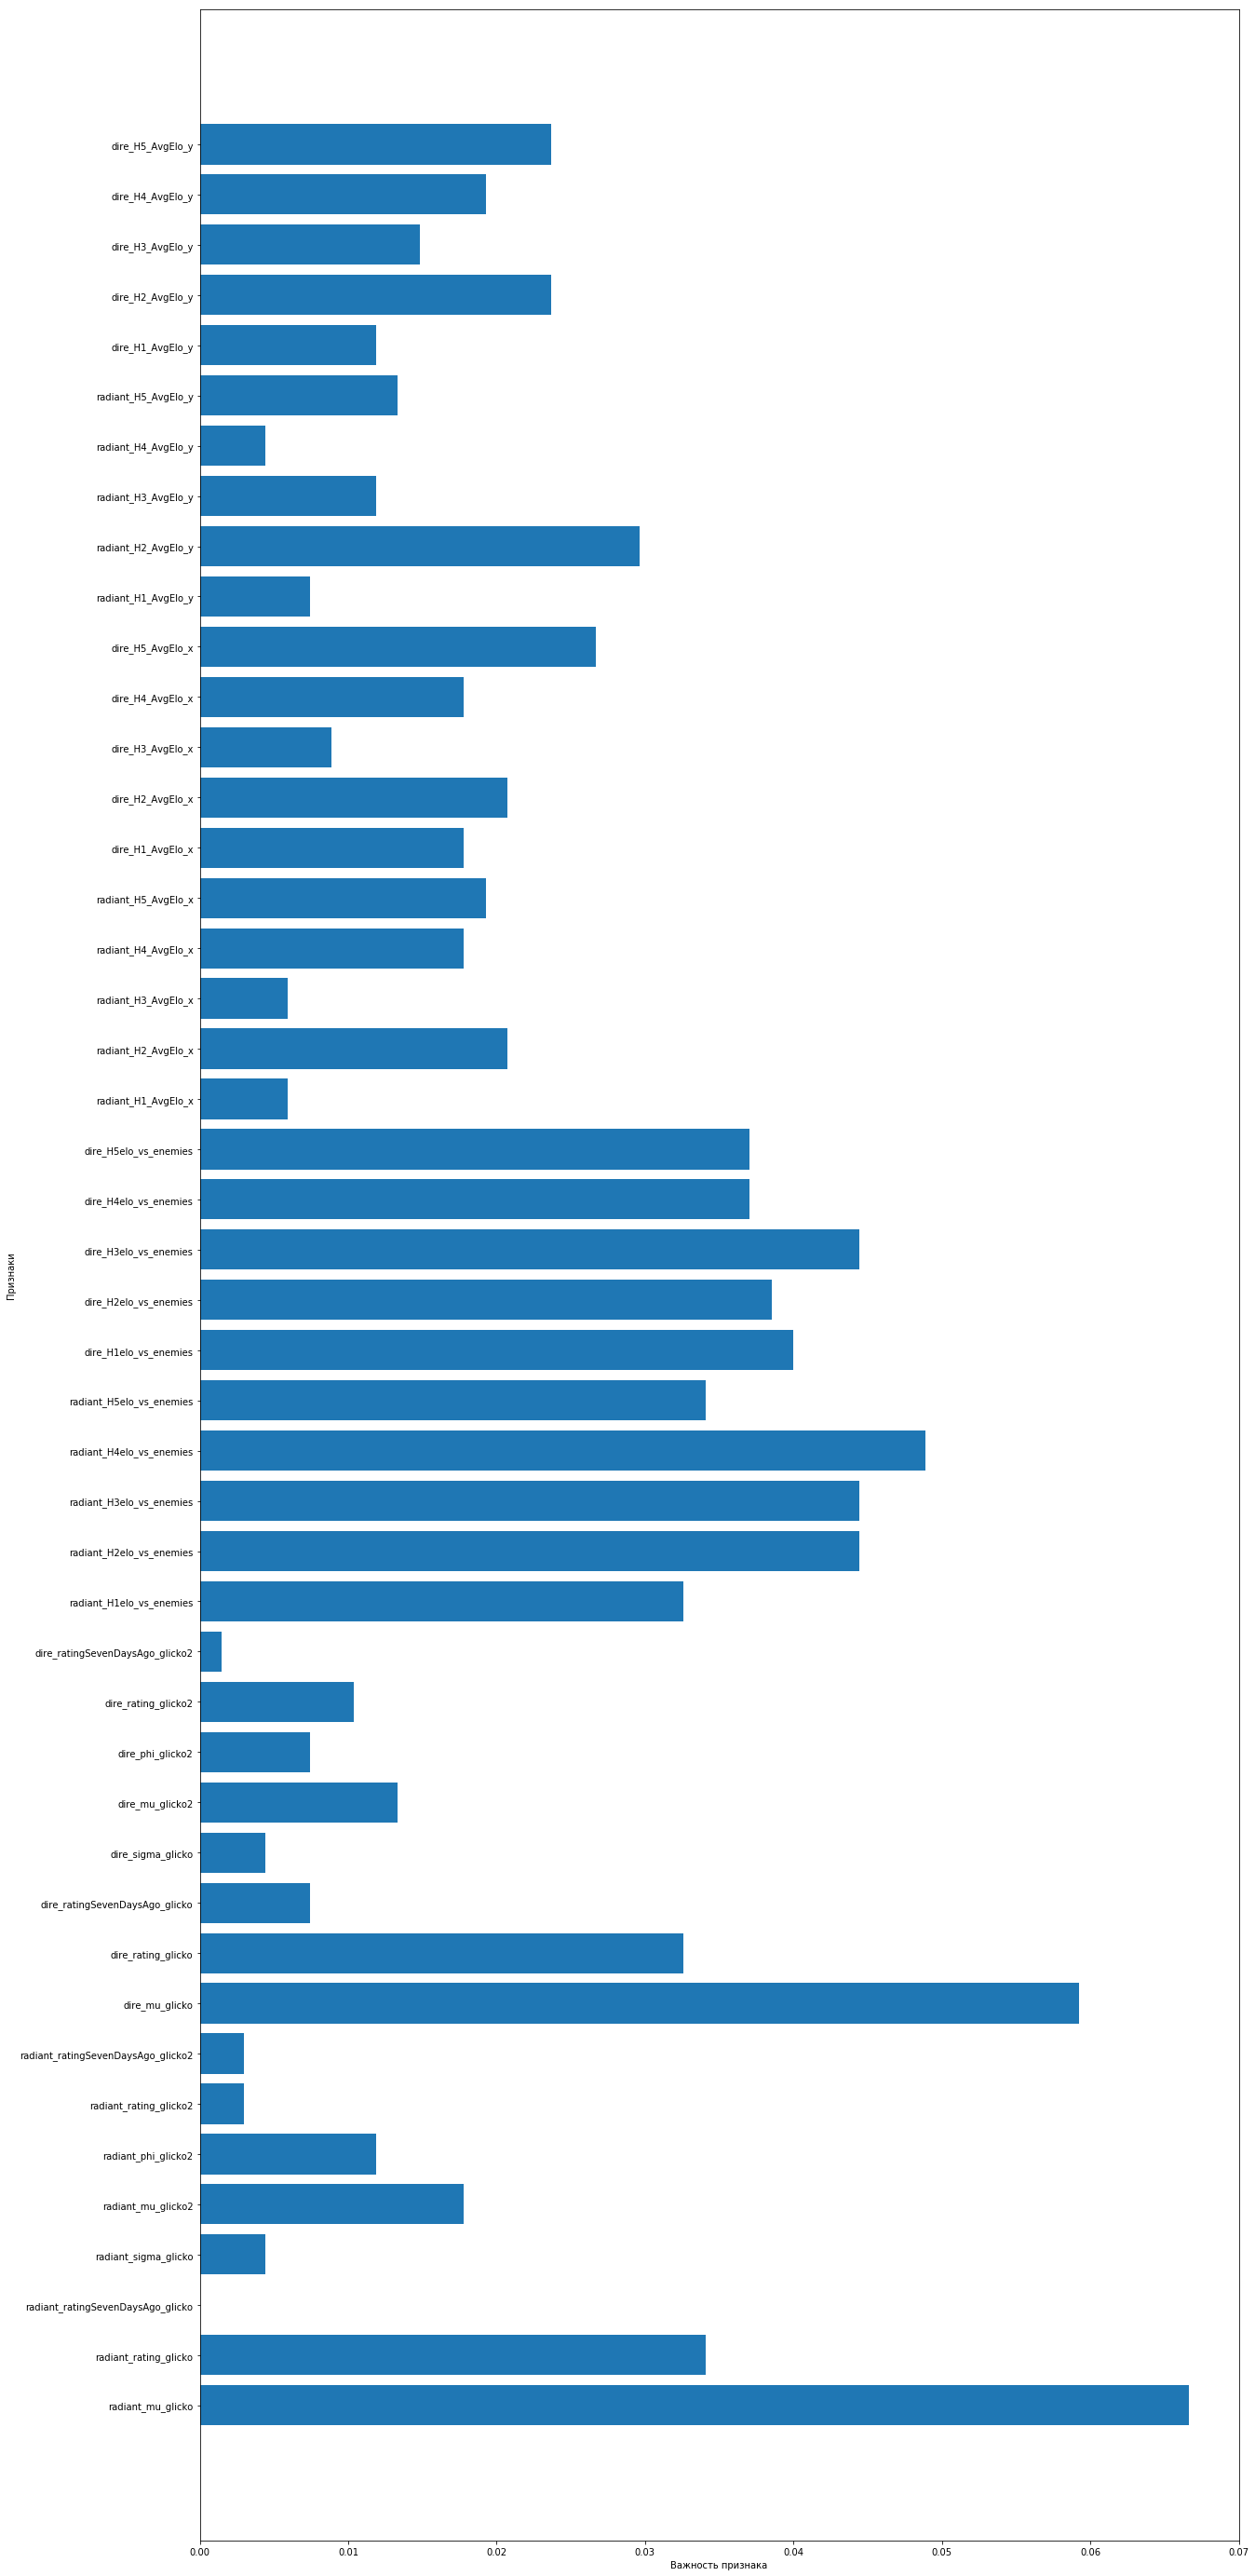

In [138]:
# важность признаков в бустинге

n_features = X_train.shape[1]
plt.figure(figsize=(20,50))
plt.barh(range(n_features), best_GB.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.show()